In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, \
 BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools


import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

from __future__ import absolute_import, division, print_function, unicode_literals


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/CVFall2023

/content/drive/MyDrive/ColabNotebooks/CVFall2023


In [ ]:
train_path = 'student-activity/TRAIN'
valid_path = 'student-activity/TEST'

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

folders = glob(train_path + '/*')

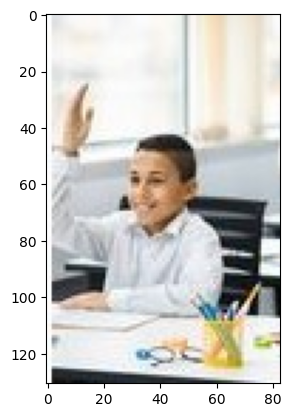

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

# Image Setting

In [ ]:
print(image.load_img(np.random.choice(image_files)))

In [ ]:
IMAGE_SIZE = [28,28]

epochs = 16
batch_size = 32
file_path = "/content/drive/MyDrive/ColabNotebooks/CVFall2023/checkpoint"
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True),
ModelCheckpoint(file_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

Found 112 images belonging to 3 classes.
{'DozeOff': 0, 'ListenLecture': 1, 'RaiseHand': 2}


min: -1.0 max: 0.9843137


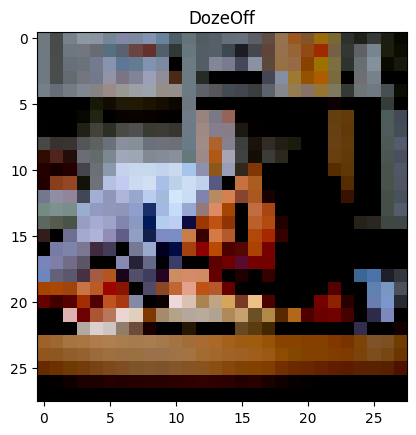

In [ ]:
# test generator to see how it works and some other useful things

#get label mapping for confustion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 360 images belonging to 3 classes.
Found 112 images belonging to 3 classes.


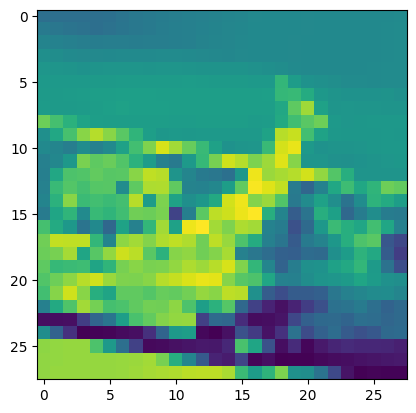

In [ ]:
for image, label in train_generator:
  plt.imshow(image[0])
  plt.show()
  break

In [ ]:
# #Loading data
# fashion_mnist = tf.keras.datasets.fashion_mnist
# (X_train,y_train), (X_test,y_test) = fashion_mnist.load_data()
# X_train, X_test = X_train/255.0, X_test/255.0

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# X_train.shape

(60000, 28, 28)

In [ ]:
#reshape
# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)
# X_train.shape

(60000, 28, 28, 1)

In [ ]:
#Build network
i = Input(shape = IMAGE_SIZE + [1])
x = Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh')(i)
x = AveragePooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh')(x)
x = AveragePooling2D((2, 2), strides=(2, 2))(x)
x = Flatten()(x)
x = Dense(120, activation='tanh')(x)
x = Dense(84, activation='tanh')(x)
x = Dense(len(folders), activation='softmax')(x)

model = Model(i,x)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# r = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=15)
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    batch_size=128,
    callbacks=[callback]
)

Epoch 1/16
12/12 [==============================] - 56s 5s/step - loss: 0.9374 - accuracy: 0.5139 - val_loss: 0.8898 - val_accuracy: 0.5714
Epoch 2/16
12/12 [==============================] - 2s 196ms/step - loss: 0.7991 - accuracy: 0.5917 - val_loss: 0.8543 - val_accuracy: 0.5000
Epoch 3/16
12/12 [==============================] - 2s 196ms/step - loss: 0.7800 - accuracy: 0.6028 - val_loss: 0.8397 - val_accuracy: 0.5625
Epoch 4/16
12/12 [==============================] - 2s 187ms/step - loss: 0.7394 - accuracy: 0.6222 - val_loss: 0.7660 - val_accuracy: 0.5804
Epoch 5/16
12/12 [==============================] - 3s 229ms/step - loss: 0.7505 - accuracy: 0.5833 - val_loss: 0.7663 - val_accuracy: 0.6071
Epoch 6/16
12/12 [==============================] - 3s 255ms/step - loss: 0.7281 - accuracy: 0.6389 - val_loss: 0.8071 - val_accuracy: 0.5714
Epoch 7/16
12/12 [==============================] - 2s 204ms/step - loss: 0.7313 - accuracy: 0.6083 - val_loss: 0.8723 - val_accuracy: 0.5625
Epoch 8/

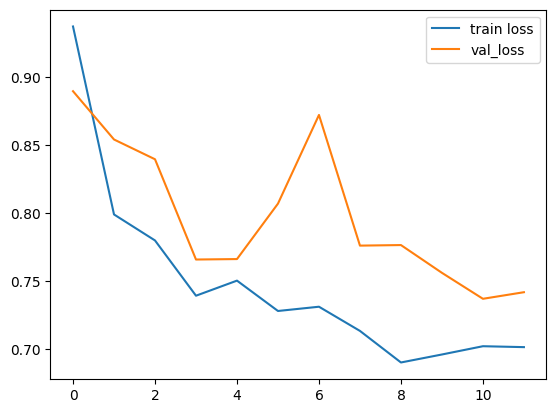

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()